In [2]:
import sys

sys.path.append('..')

from Data_Collection.tool import datasets
from tqdm import tqdm
import pickle
import os
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt

from Ablation.removeEntity import remove_entities

n_split = 5

In [3]:
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

In [7]:
def vis_heatmap(ds_name, rr, p_name, split):
    vis_df = pd.DataFrame(rr)
    heatmap_p = vis_df.pivot(index='top', columns='bottom', values='p_remaining_test')
    heatmap_q = vis_df.pivot(index='top', columns='bottom', values='q_remaining_test')

    r = []

    for row in heatmap_p.index:
        t = []
        for col in heatmap_p.columns:
            t.append(str(heatmap_p.loc[row, col]) + '\n(' + human_format(heatmap_q.loc[row, col]) + ')')
        r.append(t)

    ax = sns.heatmap(heatmap_p, annot=r, linewidth=.5, cmap='RdYlGn', fmt = '', annot_kws={"fontsize":8})
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_title('{} (Split {}) - {}'.format(ds_name, split, p_name.upper()))
    plt.show()


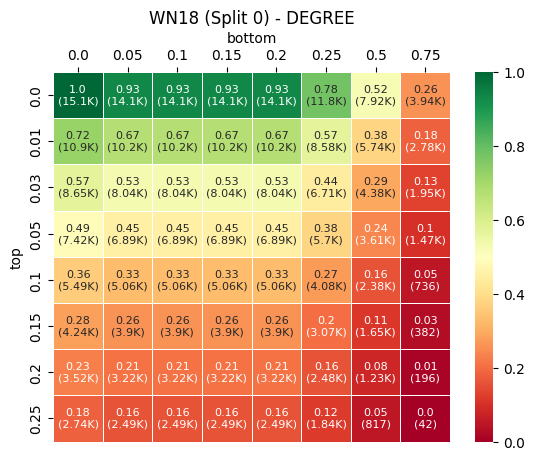

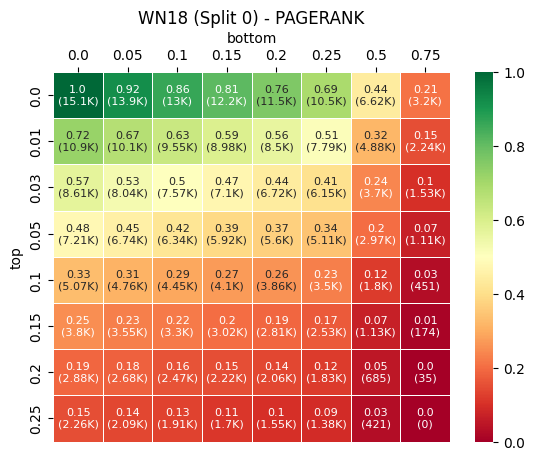

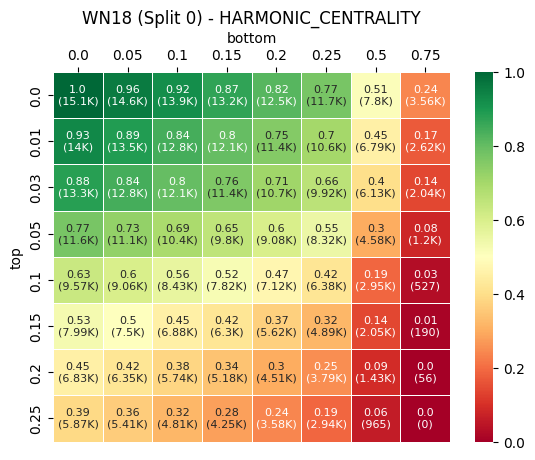

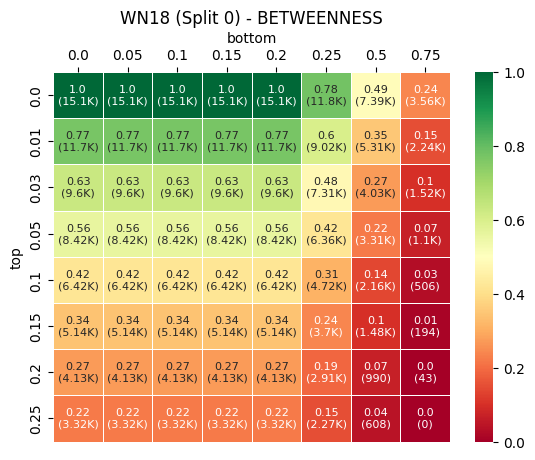

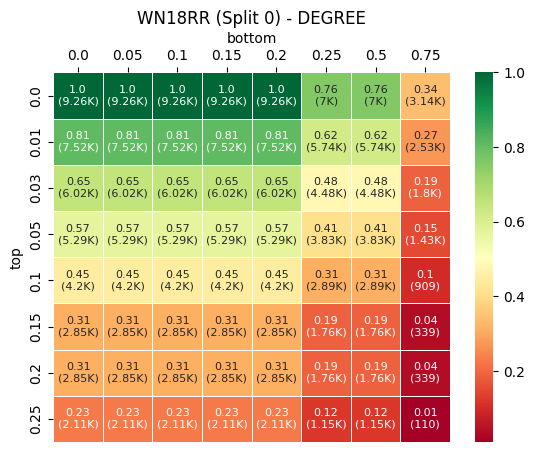

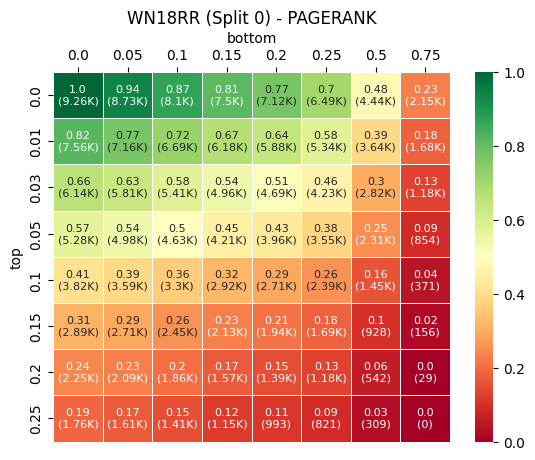

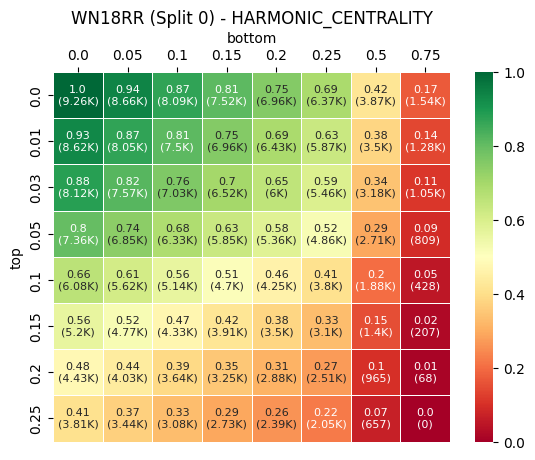

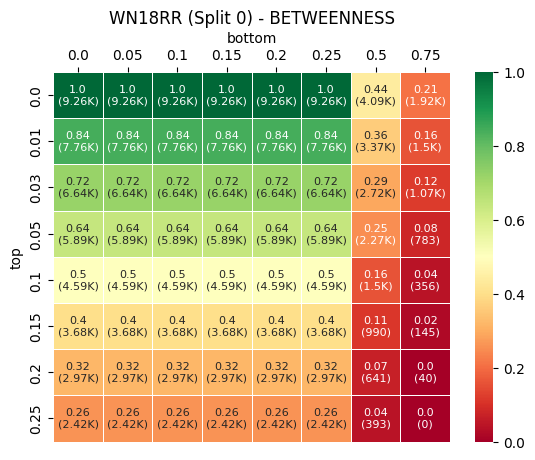

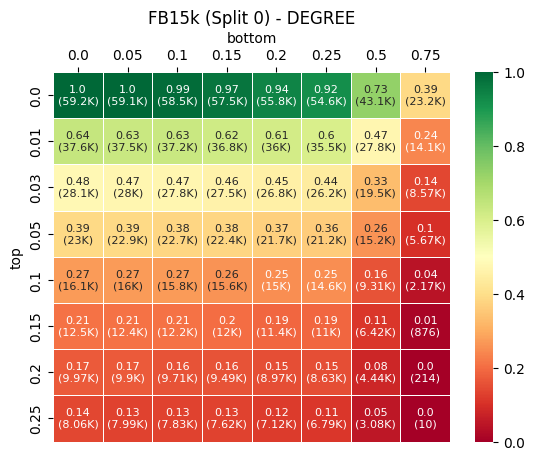

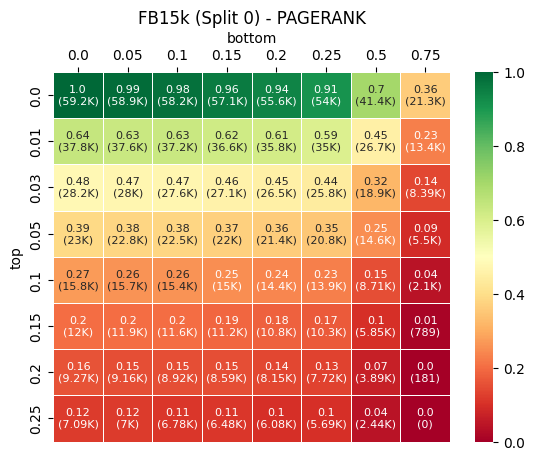

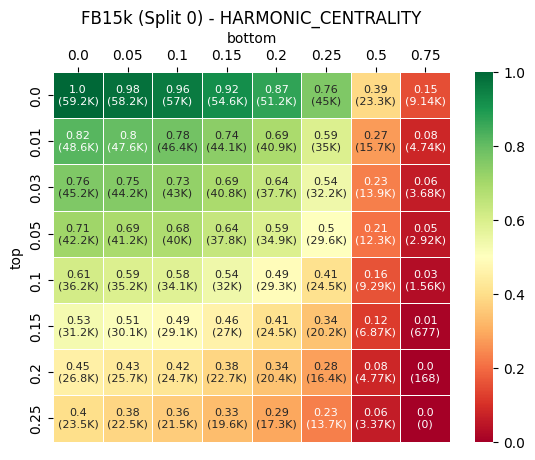

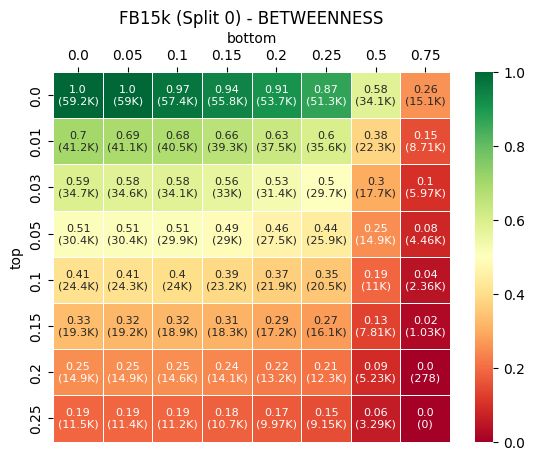

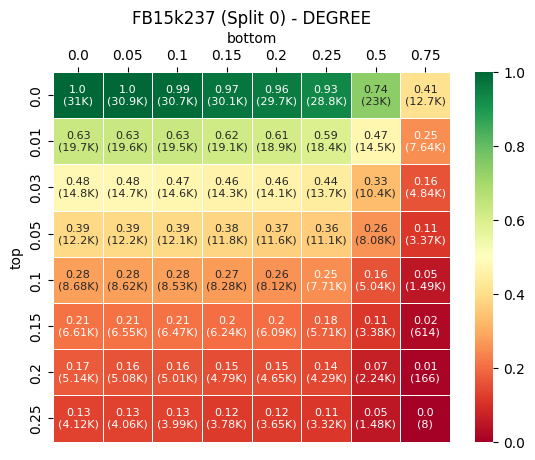

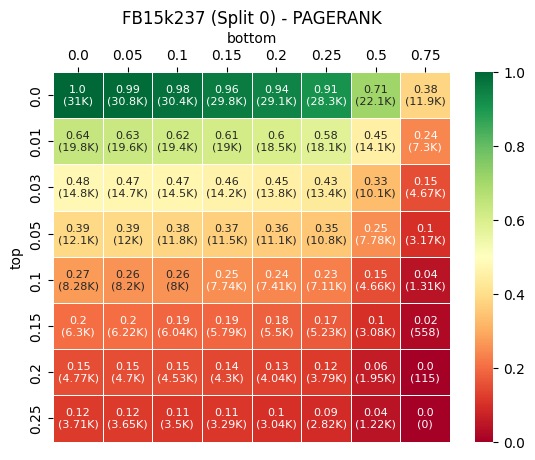

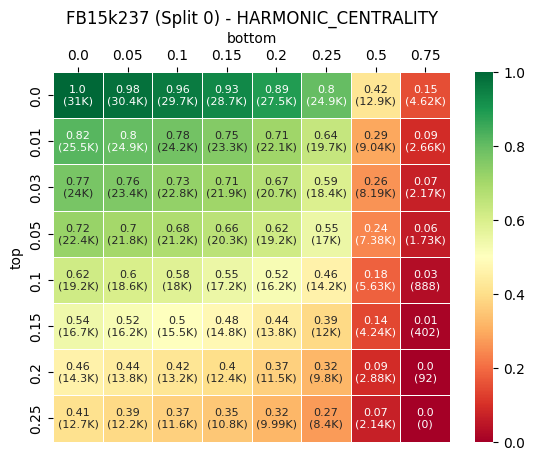

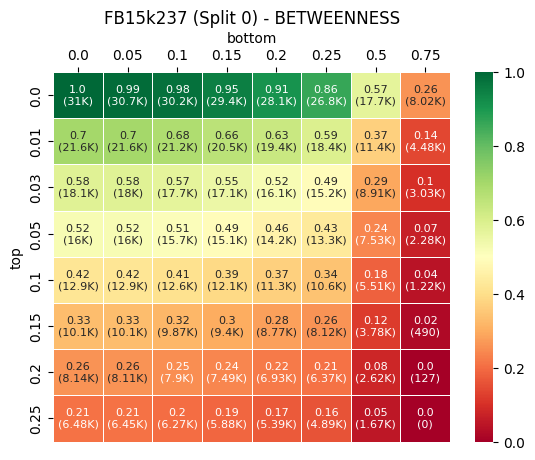

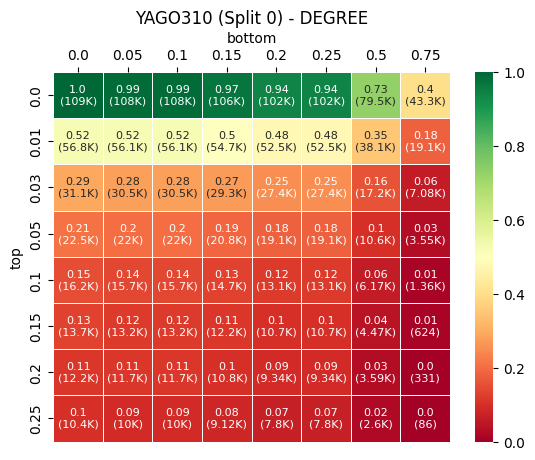

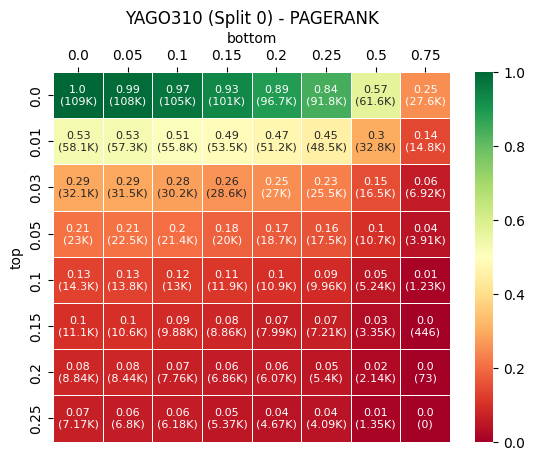

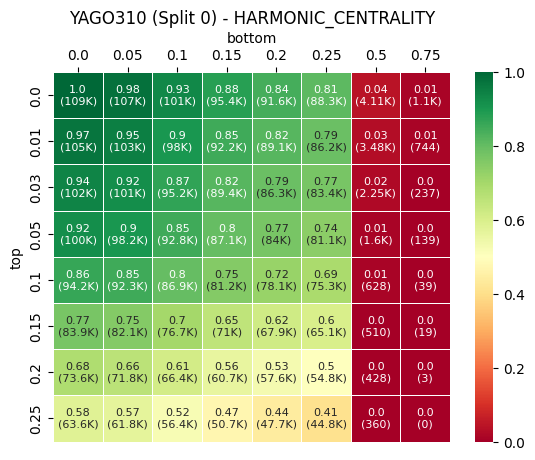

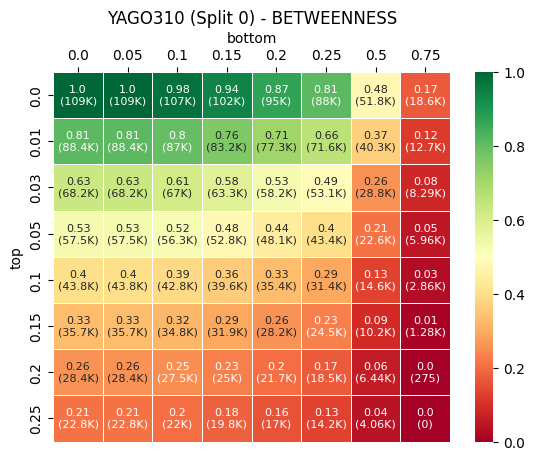

In [11]:
for dataset_name in datasets:

    for i in range(n_split):
        folder_path = '../Data_Collection/Datasets_Complete/{}/Split_{}/'.format(dataset_name, i)
        os.makedirs(folder_path, exist_ok=True)
        with open(os.path.join(folder_path, 'instance.pickle'), 'rb') as f:
            pick = pickle.load(f)

        df_measures = pick['measures_training']['dataframe']


        dataset = pick['dataset']

        training_df = pd.DataFrame(dataset['training'], columns=['h', 'r', 't'])
        testing_df = pd.DataFrame(dataset['testing'], columns=['h', 'r', 't'])

        n_entities = len(df_measures)

        for property_name in ['degree', 'pagerank', 'harmonic_centrality', 'betweenness']:

            sorted_desc_df = df_measures.sort_values(property_name, ascending=False)
    
            res = []
            original_size = len(testing_df)
    
    
    
            for remove_top in [0, 0.01, 0.03, 0.05, 0.10, 0.15, 0.20, 0.25]:
    
                quantile_top = sorted_desc_df.quantile(1 - remove_top)[property_name]
                top_entities_to_be_removed = sorted_desc_df[sorted_desc_df[property_name] > quantile_top]['entity'].to_list()
    
                for remove_bottom in [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75]:
                    quantile_bottom = sorted_desc_df.quantile(remove_bottom)[property_name]

                    bottom_entities_to_be_removed = sorted_desc_df[sorted_desc_df[property_name] < quantile_bottom]['entity'].to_list()
    
                    entities_to_be_removed = top_entities_to_be_removed + bottom_entities_to_be_removed
                    entities_to_be_removed = set(entities_to_be_removed)
    
                    new_training_df = remove_entities(df_dataset=training_df, entities_to_be_removed=entities_to_be_removed)
                    new_testing_df = remove_entities(df_dataset=testing_df, entities_to_be_removed=entities_to_be_removed)
                    p_remaining_test = round(len(new_testing_df) / original_size, 2)
    
                    res.append({'top': remove_top,
                                'bottom': remove_bottom,
                                'p_remaining_test': p_remaining_test,
                                'q_remaining_test': len(new_testing_df)})
    
            vis_heatmap(dataset_name, res, property_name, i)

        break # Rimuovere questo break per visualizzare tutti gli split
